In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, binarize
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix
from math import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [3]:
df = pd.read_csv("Heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
# Analisemos si las clases estàn balanceadas

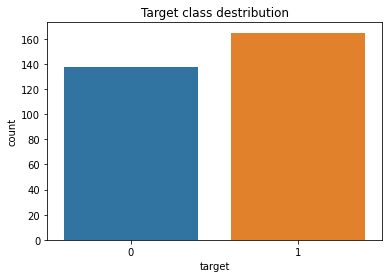

In [6]:
plt.plot()
sns.countplot(x='target', data=df)
plt.title('Target class destribution');

In [ ]:
# Las clases estàn balanceadas, analicemos un heatmap

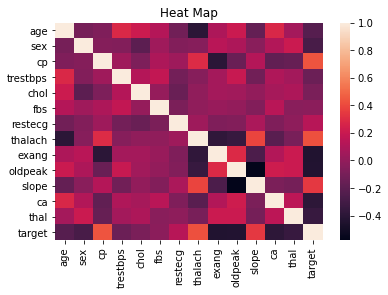

In [7]:
plt.plot()
sns.heatmap(df.corr())
plt.title('Heat Map');

In [ ]:
# varias caracteristicas tienen buena correlaciòn lineal con el target, slope, cp,exang, oldpeak,ca.

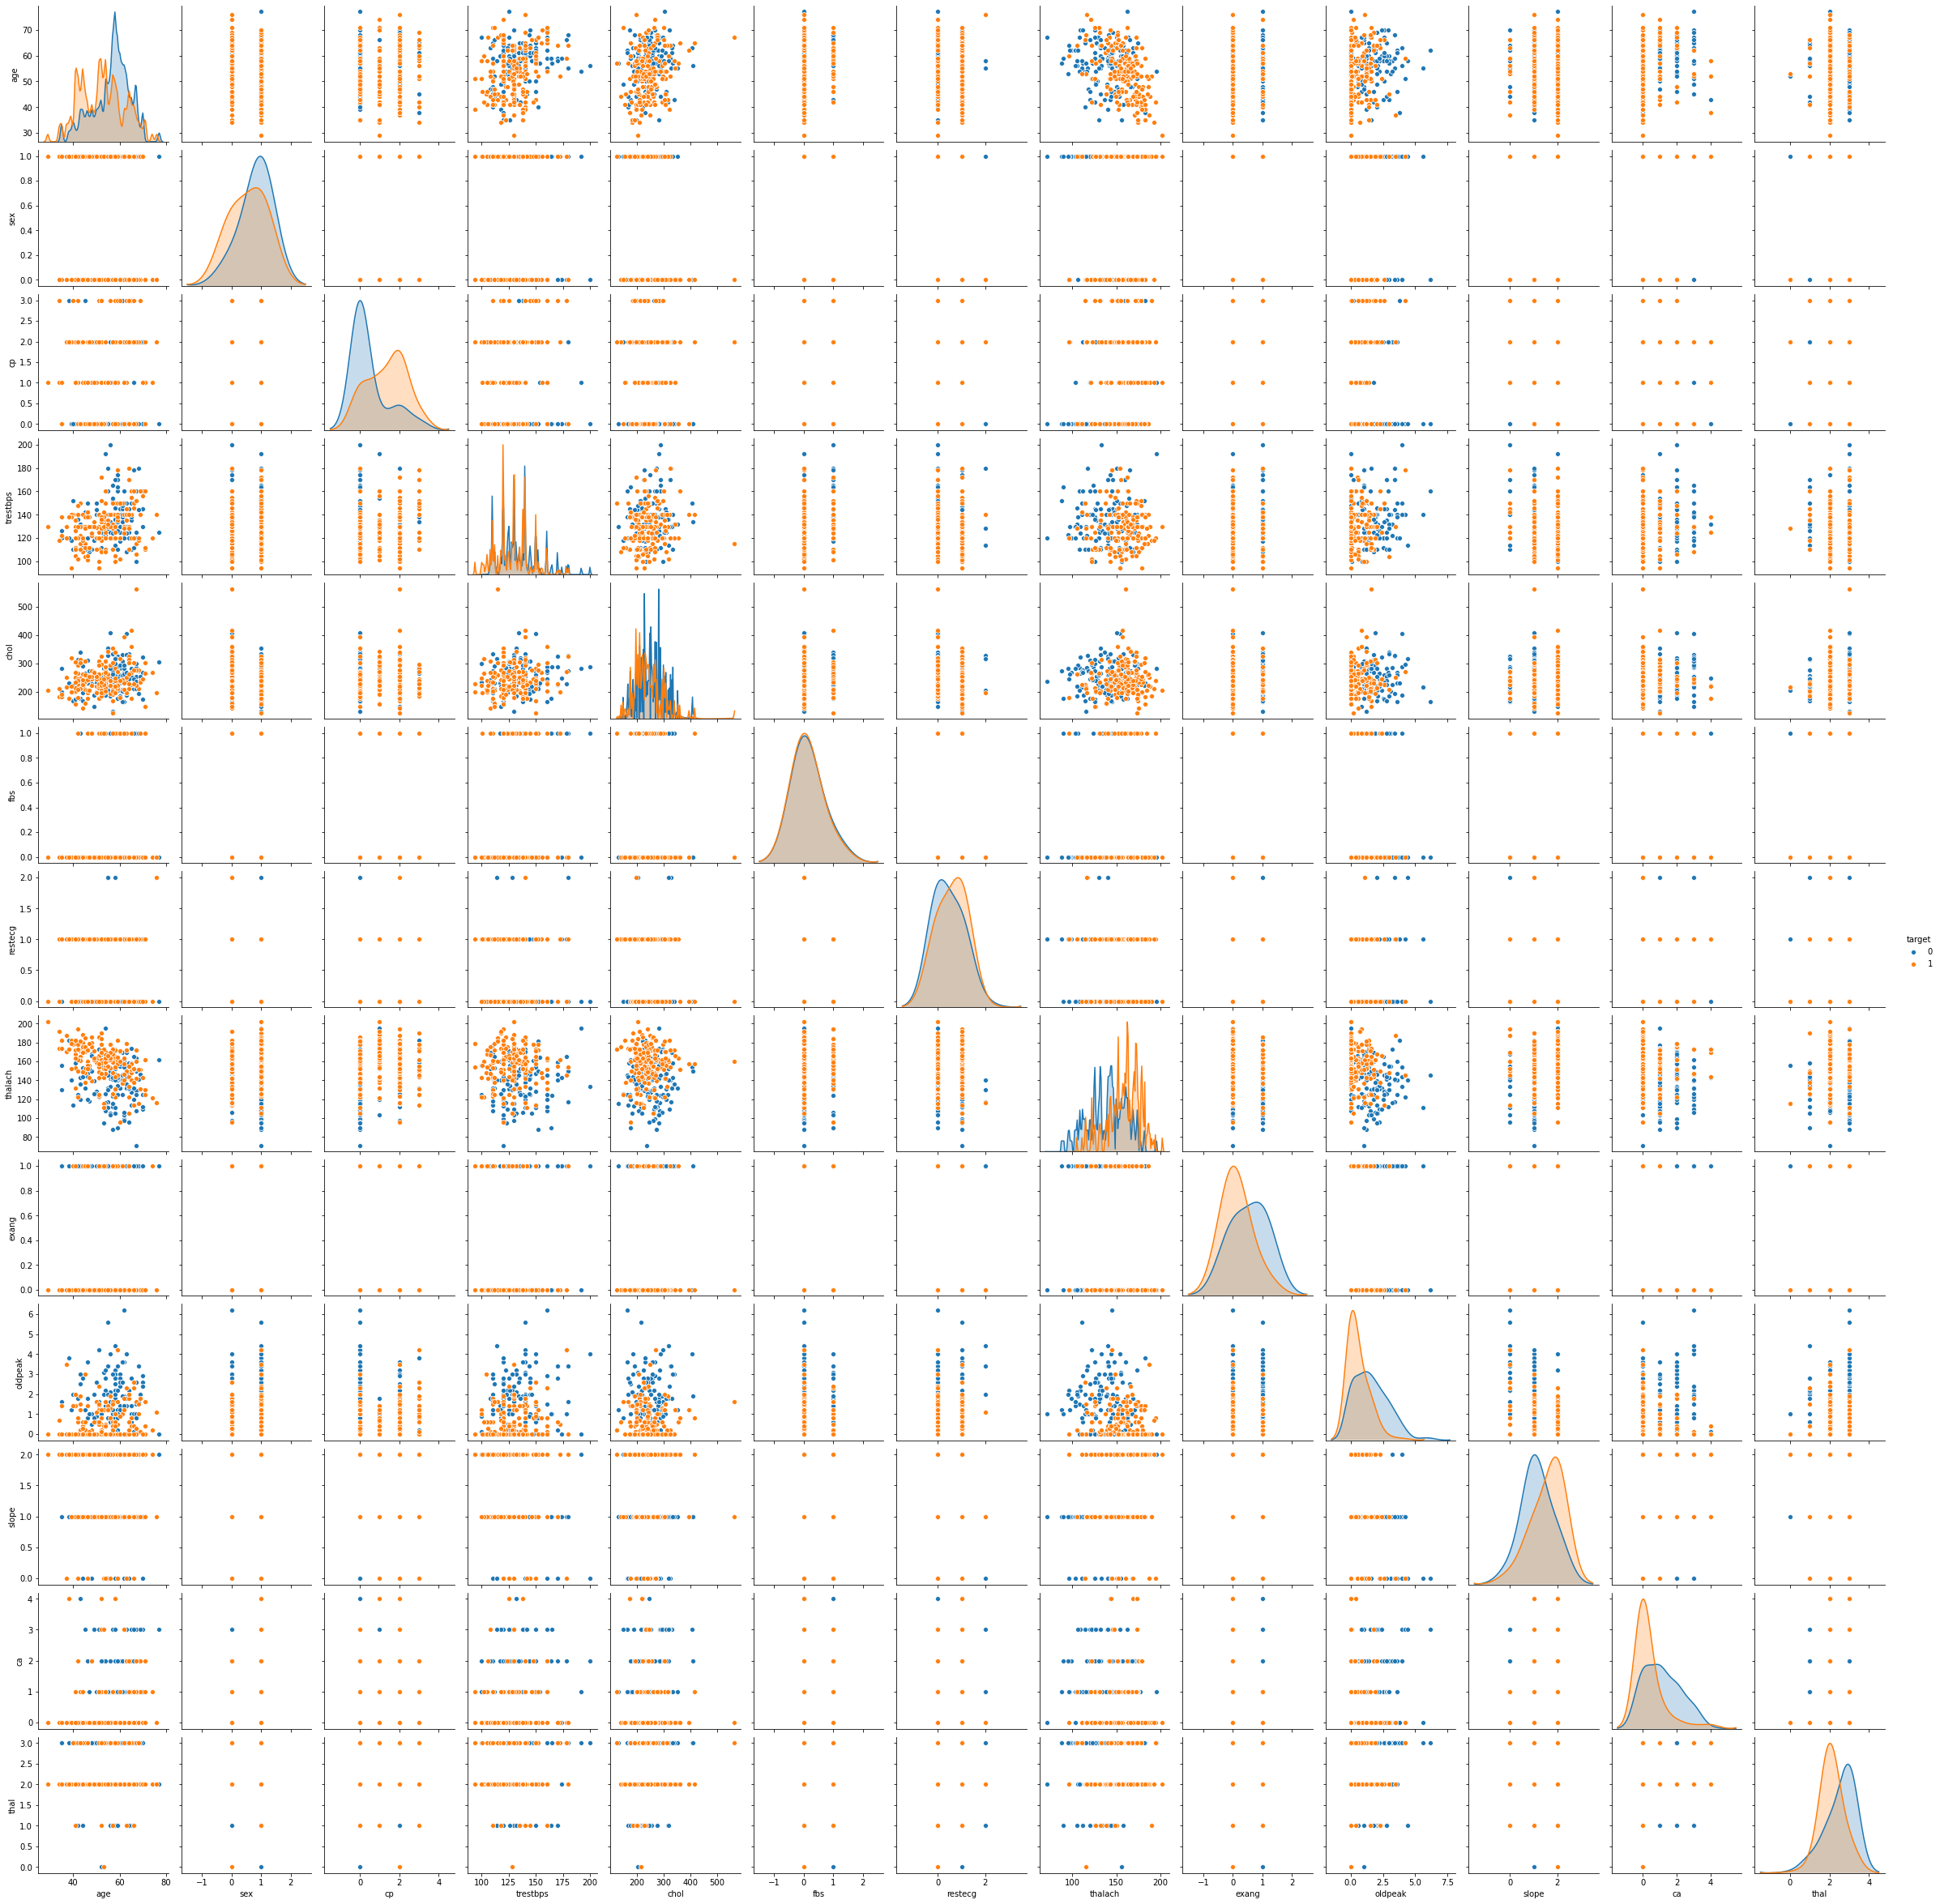

In [8]:
sns.pairplot(df, hue='target', diag_kws={'bw':0.5});

In [ ]:
# con estas caracteristicas utilizaremos Regresiòn Logistica

In [9]:
X = df.drop(['target'], axis=1).to_numpy()
y = df['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [10]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
log_reg = LogisticRegression(solver='liblinear')
params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(0, 0.6, 20)
}

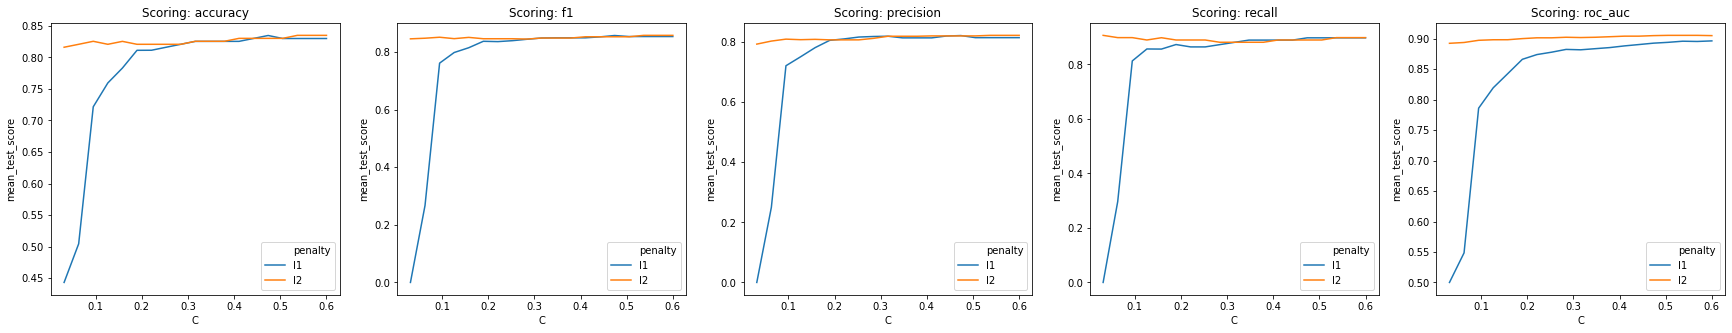

In [12]:
scoring_list = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
fig, axs = plt.subplots(1, len(scoring_list), figsize=(30,5))
for i in range(len(scoring_list)):
    scoring = scoring_list[i]
    grd = GridSearchCV(log_reg, params, scoring=scoring, cv=5)
    grd.fit(X_train, y_train);
    C = [param['C'] for param in grd.cv_results_['params']]
    penalty = [param['penalty'] for param in grd.cv_results_['params']]
    mean_test_score = grd.cv_results_['mean_test_score']
    res = pd.DataFrame({'mean_test_score': mean_test_score, 'C': C, 'penalty': penalty})
    sns.lineplot(x="C", y="mean_test_score", hue="penalty", data=res, ax=axs[i])
    axs[i].set_title('Scoring: ' + scoring)

In [13]:
log_reg = LogisticRegression(C=0.2, penalty='l2', solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print('Recall: {:.4f}'.format(recall_score(y_test, y_pred)))
print('ROC-AUC: {:.4f}'.format(roc_auc_score(y_test, y_pred)))

Recall: 0.8936
ROC-AUC: 0.7536


In [14]:
def get_features_importance(df, target, lin_predictor):
    '''
    Input:
        `df` - Pandas DataFrame that was used for model training. It stores features names.
        `target` - target cloumn name.
        `lin_predictor` - linear model that was thained on this data.
    Output:
        `features_importance` - Pandas DataFrame that stores the absolute values of coefficients 
            in linear model which shows features importance.
        barplot of features importance
    '''
    features = list(df.columns.values)
    features.remove(target)
    importance = [abs(coef) for coef in lin_predictor.coef_[0]]
    features_importance = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(['Importance'], ascending=False)
    features_importance = features_importance.reset_index().drop('index', axis=1)
    fig, ax = plt.subplots(figsize=(25,5))
    bar = sns.barplot(x='Feature', y='Importance', data=features_importance, ax=ax);
    ax.set_xticklabels(features, rotation=90);
    ax.set_title('Features Importance')
    for index, row in features_importance.iterrows():
        bar.text(index, row['Importance'], round(row['Importance'], 4), color='black', ha="center", fontsize=8)

    return features_importance

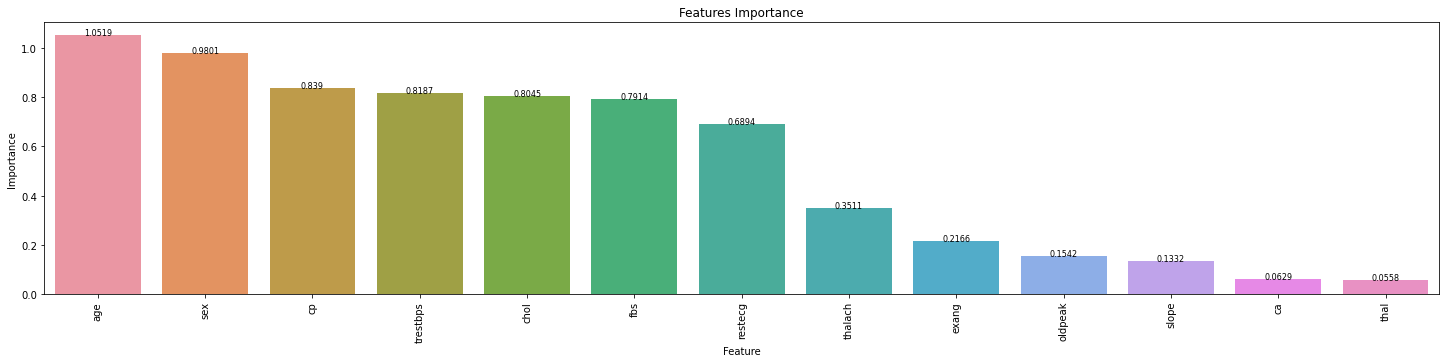

In [15]:
features_importance = get_features_importance(df, 'target', log_reg)

In [16]:
def get_polynomial_features(df, feature, features_interaction):
    df_res = pd.DataFrame()
    for f in features_interaction:
        df_res[feature + '^2'] = df[feature]**2
        df_res[feature + '-' + f] = sqrt(2) * df[feature] * df[f]
        df_res[f + '^2'] = df[f]**2
    return df_res  

In [19]:
all_features = list(df.columns.values)
all_features.remove('target')
df_oldpeak = get_polynomial_features(df, 'oldpeak', all_features)

In [20]:
df_2 = pd.concat([df, df_oldpeak], axis=1)
df_2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,oldpeak^2,oldpeak-age,age^2,oldpeak-sex,sex^2,oldpeak-cp,cp^2,oldpeak-trestbps,trestbps^2,oldpeak-chol,chol^2,oldpeak-fbs,fbs^2,oldpeak-restecg,restecg^2,oldpeak-thalach,thalach^2,oldpeak-exang,exang^2,oldpeak-oldpeak,oldpeak-slope,slope^2,oldpeak-ca,ca^2,oldpeak-thal,thal^2
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,5.29,204.919545,3969,3.252691,1,9.758074,9,471.640223,21025,757.877048,54289,3.252691,1,0.000000,0,487.903679,22500,0.000000,0,7.481190,0.000000,0,0.0,0,3.252691,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,12.25,183.140656,1369,4.949747,1,9.899495,4,643.467171,16900,1237.436867,62500,0.000000,0,4.949747,1,925.602777,34969,0.000000,0,17.324116,0.000000,0,0.0,0,9.899495,4
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,1.96,81.175858,1681,0.000000,0,1.979899,1,257.386868,16900,403.899393,41616,0.000000,0,0.000000,0,340.542626,29584,0.000000,0,2.771859,3.959798,4,0.0,0,3.959798,4
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,0.64,63.356768,3136,1.131371,1,1.131371,1,135.764502,14400,267.003521,55696,0.000000,0,1.131371,1,201.384011,31684,0.000000,0,0.905097,2.262742,4,0.0,0,2.262742,4
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,0.36,48.366104,3249,0.000000,0,0.000000,0,101.823376,14400,300.378961,125316,0.000000,0,0.848528,1,138.310086,26569,0.848528,1,0.509117,1.697056,4,0.0,0,1.697056,4


In [21]:
X_2 = df_2.drop(['target'], axis=1).to_numpy()
y_2 = df_2['target'].to_numpy()

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=0, shuffle=True)

In [22]:
log_reg_2 = LogisticRegression(C=0.2, penalty='l2', solver='liblinear')
log_reg_2.fit(X_train_2, y_train_2)
y_pred_2 = log_reg_2.predict(X_test_2)

In [23]:
print('Recall: {:.4f}'.format(recall_score(y_test_2, y_pred_2)))
print('ROC-AUC: {:.4f}'.format(roc_auc_score(y_test_2, y_pred_2)))

Recall: 0.9149
ROC-AUC: 0.8324


In [ ]:
# El resultado claramente mejoro

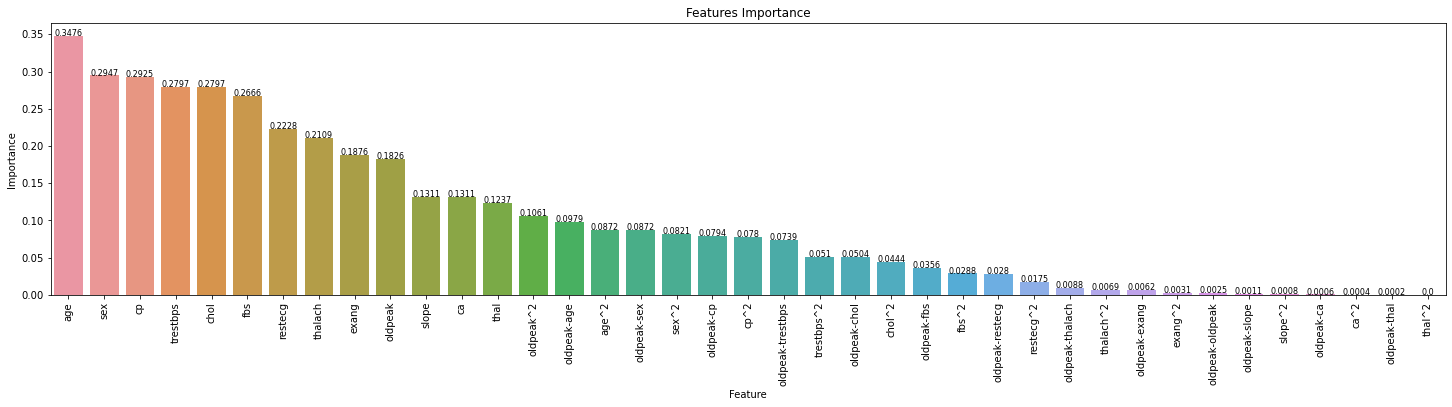

In [24]:
features_importance_2 = get_features_importance(df_2, 'target', log_reg_2)

In [25]:
features_to_remove = features_importance_2[features_importance_2['Importance'] < 0.01]['Feature'].values

In [26]:
df_3 = df_2.drop(features_to_remove, axis=1)
df_3.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,ca,thal,target,oldpeak^2,oldpeak-sex,sex^2,cp^2,oldpeak-fbs,fbs^2,oldpeak-restecg,restecg^2,oldpeak-exang,exang^2,oldpeak-oldpeak,oldpeak-slope,slope^2,oldpeak-ca,ca^2,oldpeak-thal,thal^2
0,63,1,3,145,233,1,0,150,0,0,1,1,5.29,3.252691,1,9,3.252691,1,0.000000,0,0.000000,0,7.481190,0.000000,0,0.0,0,3.252691,1
1,37,1,2,130,250,0,1,187,0,0,2,1,12.25,4.949747,1,4,0.000000,0,4.949747,1,0.000000,0,17.324116,0.000000,0,0.0,0,9.899495,4
2,41,0,1,130,204,0,0,172,0,0,2,1,1.96,0.000000,0,1,0.000000,0,0.000000,0,0.000000,0,2.771859,3.959798,4,0.0,0,3.959798,4
3,56,1,1,120,236,0,1,178,0,0,2,1,0.64,1.131371,1,1,0.000000,0,1.131371,1,0.000000,0,0.905097,2.262742,4,0.0,0,2.262742,4
4,57,0,0,120,354,0,1,163,1,0,2,1,0.36,0.000000,0,0,0.000000,0,0.848528,1,0.848528,1,0.509117,1.697056,4,0.0,0,1.697056,4


In [27]:
X_3 = df_3.drop(['target'], axis=1).to_numpy()
y_3 = df_3['target'].to_numpy()

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3, random_state=0, shuffle=True)

In [28]:
log_reg_3 = LogisticRegression(C=0.2, penalty='l2', solver='liblinear')
log_reg_3.fit(X_train_3, y_train_3)
y_pred_3 = log_reg_3.predict(X_test_3)

In [29]:
print('Recall: {:.4f}'.format(recall_score(y_test_3, y_pred_3)))
print('ROC-AUC: {:.4f}'.format(roc_auc_score(y_test_3, y_pred_3)))

Recall: 0.9362
ROC-AUC: 0.8431


In [ ]:
# la selecciòn mejoro ligeramente

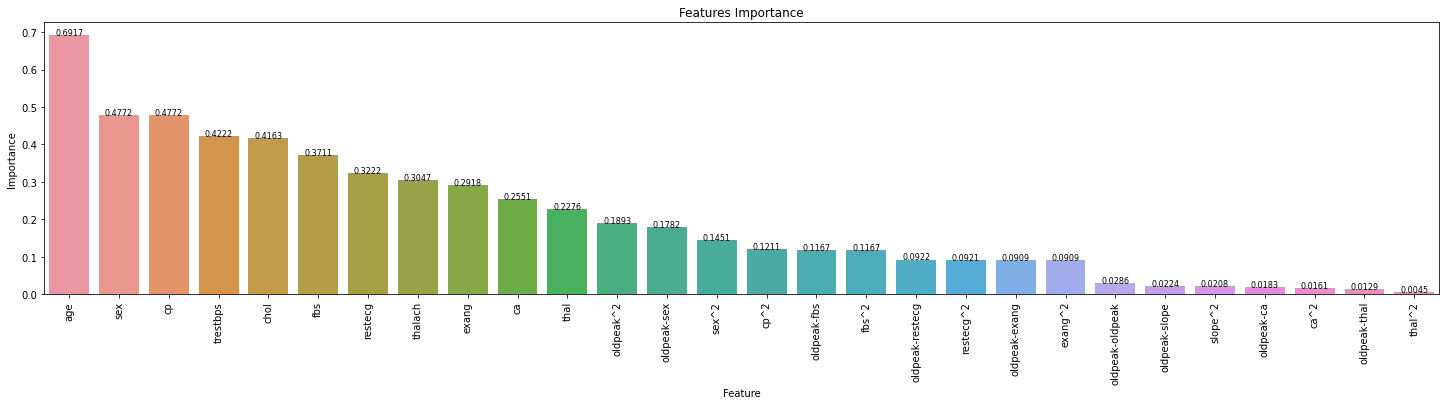

In [30]:
features_importance_3 = get_features_importance(df_3, 'target', log_reg_3)

In [31]:
# Evaluemos con la matriz de confusiòn

In [32]:
def get_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred,labels = [1,0])
    df = pd.DataFrame({'Actual Positive': cm[0,:], 'Actual Negative': cm[1,:]}, 
                      index=['Predicted\nPositive', 'Predicted\nNegative'])
    sns.heatmap(df, annot=True, cbar=False)
    plt.show()

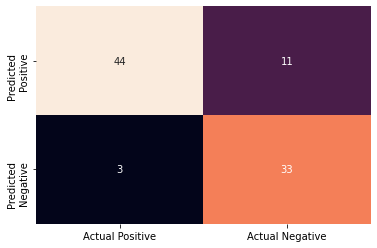

In [33]:
get_confusion_matrix(y_test_3, y_pred_3)

In [34]:
# tenemos tres falsos negativos

In [36]:
y_pred_proba = log_reg_3.predict_proba(X_test_3)

In [37]:
thresholds = np.linspace(0, 1, 100)
recall_list = []
roc_auc_list = []
for threshold in thresholds:
    y_pred_shifted = binarize(y_pred_proba, threshold=threshold)[:,1]
    recall_list.append(recall_score(y_test_3, y_pred_shifted))
    roc_auc_list.append(roc_auc_score(y_test_3, y_pred_shifted))

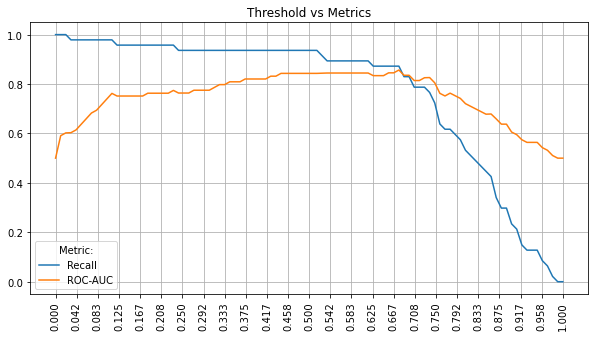

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, roc_auc_list, label='ROC-AUC')
plt.xticks(np.linspace(0, 1, 25), rotation=90)
plt.legend(title='Metric:', loc=3)
plt.grid()
plt.title('Threshold vs Metrics');